In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import gc

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Preprocess data

In [3]:
survey_df = pd.read_csv('/content/drive/MyDrive/COG403/data/SharedResponsesSurvey.csv')
print(f"survey_df: {survey_df.shape}")

<ipython-input-3-29fa468cd1a6>:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  survey_df = pd.read_csv('/content/drive/MyDrive/COG403/data/SharedResponsesSurvey.csv')


survey_df: (11286141, 27)


In [4]:
# drop all rows with NaN values
# survey_df = survey_df.dropna()
# survey_df = survey_df.replace('', np.nan)
# survey_df = survey_df.dropna()    # drop empty string rows
# print(f"survey_df (dropped nan): {survey_df.shape}")
survey_df = survey_df.dropna()  # drop all rows with NaN values
survey_df = survey_df.replace('', np.nan).dropna()    # drop empty string rows
survey_df = survey_df.replace([np.inf, -np.inf], np.nan).dropna()   # drop inf/-inf rows
print(f"survey_df (dropped nan, empty string, inf/-inf): {survey_df.shape}")

survey_df (dropped nan, empty string, inf/-inf): (8833378, 27)


In [5]:
headers = survey_df.columns
print(f"Header names: {headers}")

# Randomly sample 10% examples from survey_df
sampled_df = survey_df.sample(frac=0.1, random_state=1)

print(f"sampled_df: {sampled_df.shape}")

# Once sampled_df is created, delete the original survey_df to free up System RAM
del survey_df
gc.collect()

Header names: Index(['ResponseID', 'ExtendedSessionID', 'UserID', 'ScenarioOrder',
       'Intervention', 'PedPed', 'Barrier', 'CrossingSignal', 'AttributeLevel',
       'ScenarioTypeStrict', 'ScenarioType', 'DefaultChoice',
       'NonDefaultChoice', 'DefaultChoiceIsOmission', 'NumberOfCharacters',
       'DiffNumberOFCharacters', 'Saved', 'Template', 'DescriptionShown',
       'LeftHand', 'UserCountry3', 'Review_age', 'Review_education',
       'Review_gender', 'Review_income', 'Review_political',
       'Review_religious'],
      dtype='object')
sampled_df: (883338, 27)


0

In [6]:
sampled_df.head()

,ResponseID,ExtendedSessionID,UserID,ScenarioOrder,Intervention,PedPed,Barrier,CrossingSignal,AttributeLevel,ScenarioTypeStrict,...,Template,DescriptionShown,LeftHand,UserCountry3,Review_age,Review_education,Review_gender,Review_income,Review_political,Review_religious
6480074,isR4EQ9Ash2bnBRK7,-1516820409_9509008369262790.0,9.509008e+15,5,1,1,0,0,Hoomans,Species,...,Desktop,0.0,0.0,BRA,25.0,bachelor,female,above100000,0.74,0.67
11059629,aguaGJMLnzFgJXyKf,1974129059_2718322910552958.0,2.718323e+15,9,1,1,0,0,Fit,Fitness,...,Mobile,0.0,1.0,USA,30.0,graduate,male,above100000,0.23,0.91
8202560,R9xbKa2FEhip6YSjm,-204794111_9494983543702578.0,9.494984e+15,1,1,0,1,0,Female,Gender,...,Mobile,0.0,0.0,FRA,15.0,high,female,default,0.50,0.00
3166049,ck58YEaeBQ9jCK4QQ,258005752_6142338223464052.0,6.142338e+15,9,0,0,0,2,Hoomans,Species,...,Desktop,0.0,0.0,MEX,32.0,bachelor,male,10000,0.77,0.11
4119534,4462sqdCasKoYPhFe,981475550_796567439985240.0,7.965674e+14,2,0,0,0,2,Female,Gender,...,Desktop,0.0,1.0,SWE,23.0,bachelor,male,80000,0.00,1.00


In [7]:
# Convert Reviewer income to income level and education to education level
income_mapping = {
    'under5000': 0,          # Represent under $5,000 with 0
    '5000': 0.5,            # Lower bound for 10,000
    '10000': 1,          # Lower bound for 15,000
    '15000': 1.5,          # Lower bound for 25,000
    '25000': 2.5,          # Lower bound for 35,000
    '35000': 3.5,          # Lower bound for 50,000
    '50000': 5,          # Lower bound for 80,000
    '80000': 8,          # Lower bound for 100,000
    'above100000': 10,   # Represent Over $100,000 with 10
    'default': np.nan
}

# Mapping for 'Review_education'
education_mapping = {
    'underHigh': 1,
    'high': 2,
    'vocational': 3,
    'college': 4,
    'bachelor': 5,
    'graduate': 6,
    'other': np.nan,
    'default': np.nan
}

# Convert categorical values to numeric
sampled_df['Review_income_level'] = sampled_df['Review_income'].map(income_mapping)
sampled_df['Review_education_level'] = sampled_df['Review_education'].map(education_mapping)

# Drop rows with NaN values
sampled_df.dropna(subset=['Review_education_level', 'Review_income_level'], inplace=True)

# Drop columns Review_education and Review_income
sampled_df.drop('Review_education', axis=1, inplace=True)
sampled_df.drop('Review_income', axis=1, inplace=True)

# Drop rows where 'Review_gender' is 'other' or 'default'
sampled_df = sampled_df[~sampled_df['Review_gender'].isin(['other', 'default', 'apache helicopter', 'others'])]

# Convert columns to one-hot columns
onehot_columns = ['AttributeLevel', 'Review_education_level', 'Review_gender', 'Review_income_level']
one_hot_encoded_df = pd.get_dummies(sampled_df[onehot_columns])
one_hot_encoded_df.head()

,Review_education_level,Review_income_level,AttributeLevel_Fat,AttributeLevel_Female,AttributeLevel_Fit,AttributeLevel_High,AttributeLevel_Hoomans,AttributeLevel_Less,AttributeLevel_Low,AttributeLevel_Male,AttributeLevel_More,AttributeLevel_Old,AttributeLevel_Pets,AttributeLevel_Young,Review_gender_female,Review_gender_male
6480074,5.0,10.0,False,False,False,False,True,False,False,False,False,False,False,False,True,False
11059629,6.0,10.0,False,False,True,False,False,False,False,False,False,False,False,False,False,True
3166049,5.0,1.0,False,False,False,False,True,False,False,False,False,False,False,False,False,True
4119534,5.0,8.0,False,True,False,False,False,False,False,False,False,False,False,False,False,True
318829,1.0,3.5,True,False,False,False,False,False,False,False,False,False,False,False,False,True


In [8]:

feature_columns = ['Intervention', 'PedPed', 'Barrier', 'CrossingSignal', 'NumberOfCharacters', 'DiffNumberOFCharacters', 'Review_age', 'Review_political', 'Review_religious']
target_column = ['Saved']

X = pd.concat([sampled_df[feature_columns], one_hot_encoded_df], axis=1)
y = sampled_df[target_column]

print(f"X: {X.shape}")
print(f"y: {y.shape}")

del one_hot_encoded_df, sampled_df
gc.collect()

X: (675440, 25)
y: (675440, 1)


0

In [9]:
X.head()

,Intervention,PedPed,Barrier,CrossingSignal,NumberOfCharacters,DiffNumberOFCharacters,Review_age,Review_political,Review_religious,Review_education_level,...,AttributeLevel_Hoomans,AttributeLevel_Less,AttributeLevel_Low,AttributeLevel_Male,AttributeLevel_More,AttributeLevel_Old,AttributeLevel_Pets,AttributeLevel_Young,Review_gender_female,Review_gender_male
6480074,1,1,0,0,1,0,25.0,0.74,0.67,5.0,...,True,False,False,False,False,False,False,False,True,False
11059629,1,1,0,0,2,0,30.0,0.23,0.91,6.0,...,False,False,False,False,False,False,False,False,False,True
3166049,0,0,0,2,1,0,32.0,0.77,0.11,5.0,...,True,False,False,False,False,False,False,False,False,True
4119534,0,0,0,2,2,0,23.0,0.00,1.00,5.0,...,False,False,False,False,False,False,False,False,False,True
318829,0,1,0,1,4,0,14.0,0.80,0.09,1.0,...,False,False,False,False,False,False,False,False,False,True


In [10]:
y.head()

,Saved
6480074,0
11059629,1
3166049,1
4119534,0
318829,1


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [12]:
X_train = X_train.to_numpy(dtype=np.float32)
y_train = y_train.to_numpy(dtype=np.float32).squeeze()
X_val = X_val.to_numpy(dtype=np.float32)
y_val = y_val.to_numpy(dtype=np.float32).squeeze()
X_test = X_test.to_numpy(dtype=np.float32)
y_test = y_test.to_numpy(dtype=np.float32).squeeze()

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (405264, 25)
y_train: (405264,)
X_val: (135088, 25)
y_val: (135088,)
X_test: (135088, 25)
y_test: (135088,)


/usr/local/lib/python3.10/dist-packages/pandas/core/internals/managers.py:1794: RuntimeWarning: overflow encountered in cast
  result[rl.indexer] = arr


In [13]:
def remove_nan_rows(X, y):
    X = np.nan_to_num(X, nan=np.nan, posinf=np.nan, neginf=np.nan)
    mask = ~np.isnan(X).any(axis=1)
    return X[mask], y[mask]

In [14]:
X_train, y_train = remove_nan_rows(X_train, y_train)
X_val, y_val = remove_nan_rows(X_val, y_val)
X_test, y_test = remove_nan_rows(X_test, y_test)

# Train model and accuracy

In [15]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [16]:
# predict
val_prediction = model.predict(X_val)

# accuracy on validation
val_accuracy = accuracy_score(y_val, val_prediction)
print(f"Decision Tree Validation Accuracy: {val_accuracy:.4f}")
print(classification_report(y_val, val_prediction))

Decision Tree Validation Accuracy: 0.6569
              precision    recall  f1-score   support

         0.0       0.65      0.66      0.66     67193
         1.0       0.66      0.65      0.66     67884

    accuracy                           0.66    135077
   macro avg       0.66      0.66      0.66    135077
weighted avg       0.66      0.66      0.66    135077



In [17]:
# accuracy on test
# predict
test_prediction = model.predict(X_test)

# accuracy on validation
test_accuracy = accuracy_score(y_test, test_prediction)
print(f"Decision Tree Test Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, test_prediction))

Decision Tree Test Accuracy: 0.6566
              precision    recall  f1-score   support

         0.0       0.65      0.66      0.65     66662
         1.0       0.66      0.66      0.66     68417

    accuracy                           0.66    135079
   macro avg       0.66      0.66      0.66    135079
weighted avg       0.66      0.66      0.66    135079



In [18]:
del val_prediction, val_accuracy, test_prediction, test_accuracy
gc.collect()

0

# Evaluation with Shapely values

In [19]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 11.3 MB/s eta 0:00:00


In [20]:
import shap

In [21]:
# create tree explainer object that can calculate shap values
explainer = shap.TreeExplainer(model, feature_perturbation="interventional")

In [22]:
del X_test, X_val, y_train, y_test, y_val
gc.collect()

0

In [23]:
X_test_df = pd.DataFrame(X_train)
# print(X_train.shape)
print(X_test_df.shape)

(405233, 25)


In [24]:
# randomly sample 10 integers for the purposes of calculating shapely values
np.random.seed(42)

# Randomly sample 10 integers from 0 to 176631 (inclusive)
random_integers = np.random.randint(0, 405232, size=100)

# Print the sampled integers
print(random_integers)

[121958 146867 131932 365838 259178 119879 110268 207892  54886 137337
  87498 374871 388468 175203 191335 278167  41090 329365  64820 262913
 321879 194027 327069 252709 199041 267455 103355 235796 214176 184779
 347449 258795 392752 156730 346622 384681 149503 130523   2747 123855
  65725 129981  84654 381490  67435 319030 328947  31551 378360 273538
 331236   3890  41606 256840 349457 141699 270936 239931 239629 205041
 174073 207624  68148 252801 124243 251995 382318 154555 386502  48555
 256508 279303 372654 106530  80077 298064 200551 281601 208261 240181
 341097 315139 171829 271836 202283 196769  37065 223165  99299  11534
  40397 257750 353531 263160  55591 220884  23247  24300  82798   9268]


In [25]:
print(X_test_df.loc[random_integers].shape)

(100, 25)


In [26]:
chosen = X_test_df.loc[random_integers]
shap_values = explainer.shap_values(chosen, check_additivity=False)

In [27]:
print(shap_values.shape)
shap_values_for_class = shap_values[:, :, 1]

(100, 25, 2)


In [28]:
feature_names = X.columns.tolist()
print(shap_values_for_class.shape)
print(feature_names)

(100, 25)
['Intervention', 'PedPed', 'Barrier', 'CrossingSignal', 'NumberOfCharacters', 'DiffNumberOFCharacters', 'Review_age', 'Review_political', 'Review_religious', 'Review_education_level', 'Review_income_level', 'AttributeLevel_Fat', 'AttributeLevel_Female', 'AttributeLevel_Fit', 'AttributeLevel_High', 'AttributeLevel_Hoomans', 'AttributeLevel_Less', 'AttributeLevel_Low', 'AttributeLevel_Male', 'AttributeLevel_More', 'AttributeLevel_Old', 'AttributeLevel_Pets', 'AttributeLevel_Young', 'Review_gender_female', 'Review_gender_male']


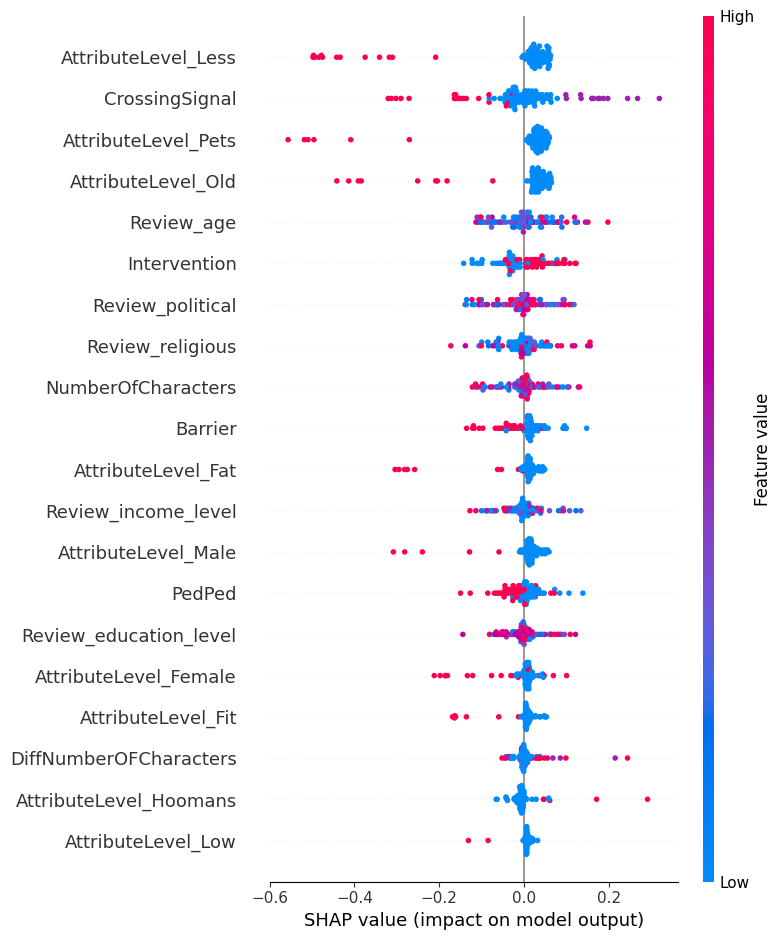

In [29]:
shap.summary_plot(shap_values_for_class,chosen, feature_names=feature_names)

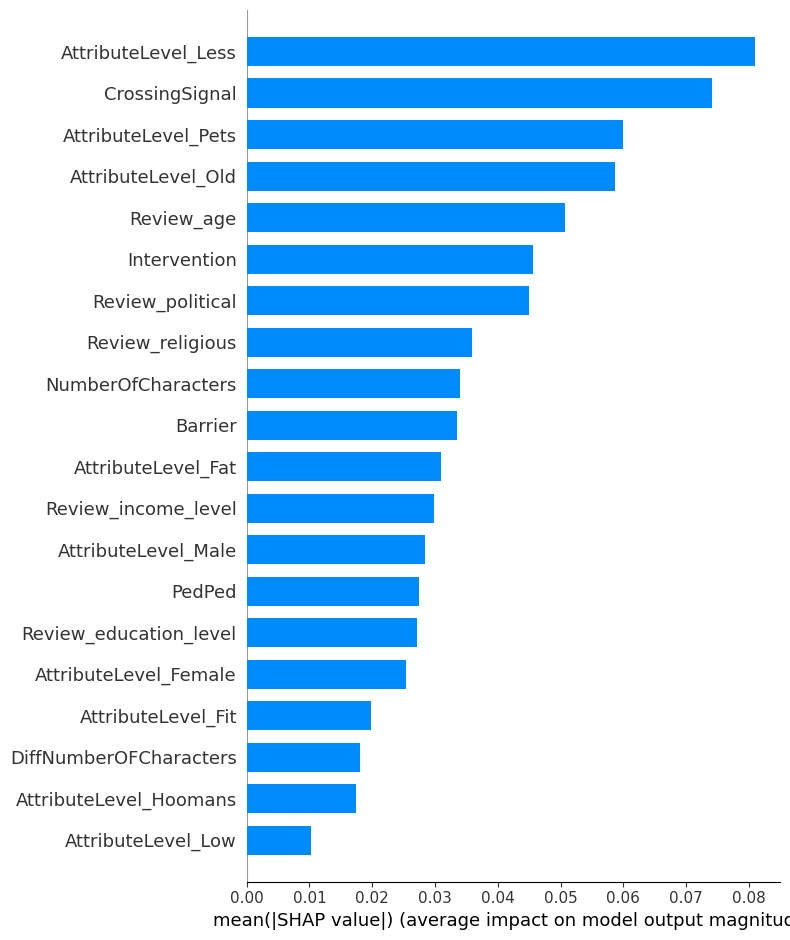

In [30]:
shap.summary_plot(shap_values_for_class, chosen, feature_names=feature_names, plot_type="bar")